In [19]:
!pip install --upgrade imbalanced-learn==0.10.1

In [20]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
data_dir = "/kaggle/input/vgg-16datscan-ppmi/DAT-SEGREGATION"
IMG_SIZE = (256, 256)
BATCH_SIZE = 8
EPOCHS = 100  

print(os.listdir(data_dir))


['NONPD', 'PD']


In [22]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_data = val_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)


Found 1112 images belonging to 2 classes.
Found 276 images belonging to 2 classes.


In [23]:

X_train = []
y_train = []

for i in range(len(train_data)):
    X_batch, y_batch = train_data[i]
    X_train.append(X_batch)
    y_train.append(y_batch)
    
    if len(X_train)*BATCH_SIZE >= train_data.samples:
        break

X_train = np.vstack(X_train)
y_train = np.hstack(y_train).astype(int)

In [24]:
n_samples, h, w, c = X_train.shape
X_train_flat = X_train.reshape(n_samples, -1)  

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_flat, y_train)

X_res = X_res.reshape(-1, h, w, c)
y_res = y_res.astype(int)

print(f"Before SMOTE: {np.bincount(y_train)}")
print(f"After SMOTE: {np.bincount(y_res)}")


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

Before SMOTE: [196 916]
After SMOTE: [916 916]


In [33]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE,3))

for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-30:]:
    layer.trainable = True

x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32768)          │       131,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 23,267,649 (88.76 MB)

 Trainable params: 23,202,113 (88.51 MB)

 Non-trainable params: 65,536 (256.00 KB)

In [34]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)


In [35]:
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, min_lr=1e-6)

In [36]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr],
)


Epoch 1/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 43s 233ms/step - accuracy: 0.7778 - loss: 0.6581 - precision_3: 0.8490 - recall_3: 0.8926 - val_accuracy: 0.8188 - val_loss: 0.4347 - val_precision_3: 0.8321 - val_recall_3: 0.9781 - learning_rate: 3.0000e-04
Epoch 2/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 32s 231ms/step - accuracy: 0.7886 - loss: 0.5594 - precision_3: 0.8505 - recall_3: 0.9083 - val_accuracy: 0.8261 - val_loss: 102.2614 - val_precision_3: 0.8261 - val_recall_3: 1.0000 - learning_rate: 3.0000e-04
Epoch 3/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 31s 221ms/step - accuracy: 0.8108 - loss: 0.4260 - precision_3: 0.8457 - recall_3: 0.9439 - val_accuracy: 0.8261 - val_loss: 0.9099 - val_precision_3: 0.8261 - val_recall_3: 1.0000 - learning_rate: 3.0000e-04
Epoch 4/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 31s 220ms/step - accuracy: 0.8093 - loss: 0.4278 - precision_3: 0.8327 - recall_3: 0.9606 - val_accuracy: 0.8261 - val_loss: 4305.5596 - val_precision_3: 0.8261 - val_recall_3: 1.0000 - learning_rate: 3.0000

In [29]:
y_pred_prob = model.predict(val_data)
y_pred = (y_pred_prob > 0.5).astype(int)
y_true = val_data.classes

print(classification_report(y_true, y_pred, target_names=['NONPD', 'PD'], zero_division=0))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step
              precision    recall  f1-score   support

       NONPD       0.67      0.25      0.36        48
          PD       0.86      0.97      0.91       228

    accuracy                           0.85       276
   macro avg       0.76      0.61      0.64       276
weighted avg       0.83      0.85      0.82       276

Confusion Matrix:
 [[ 12  36]
 [  6 222]]


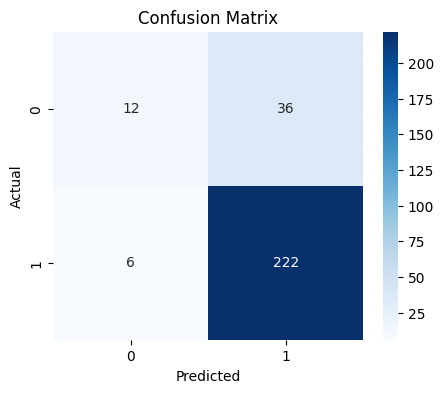

In [30]:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


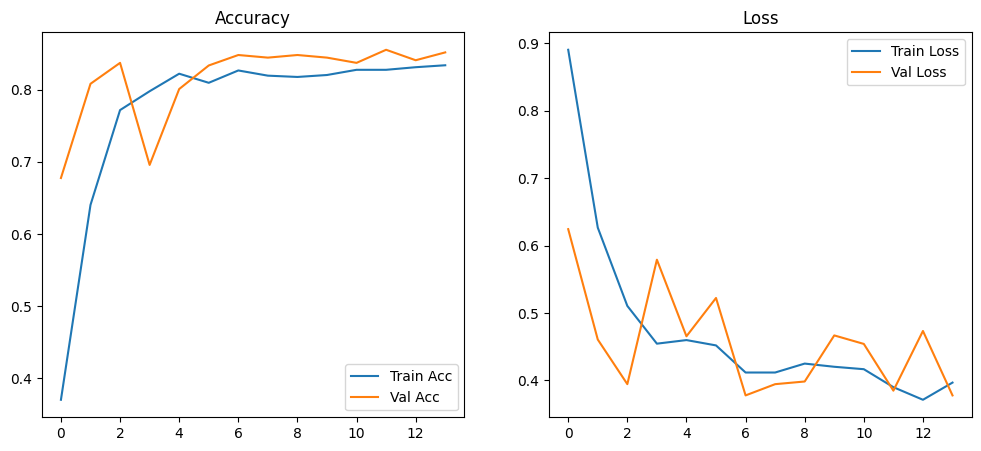

In [31]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()
